# RSNA pneumonia detection no-augmented maskrcnn

In [1]:
import os
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import glob
from sklearn.model_selection import KFold
import pydicom
from tqdm import tqdm_notebook
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor, MaskRCNN
from torchvision.models.detection import maskrcnn_resnet50_fpn
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from sklearn.model_selection import ShuffleSplit
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.rpn import RPNHead
from torchvision import transforms
import torchvision.transforms.functional as F
from PIL import Image, ImageDraw

In [2]:
# wget to download torchvision utils that are not included in pypi
!wget https://raw.githubusercontent.com/pytorch/vision/master/references/detection/utils.py -O utils.py
import utils

--2019-11-22 06:02:41--  https://raw.githubusercontent.com/pytorch/vision/master/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9796 (9.6K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   9.57K  --.-KB/s    in 0s      

2019-11-22 06:02:41 (66.3 MB/s) - ‘utils.py’ saved [9796/9796]



#### Freezing random seeds

In [3]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

In [4]:
def get_dicom_fps(data_dir):
    dicom_fps = glob.glob(os.path.join(data_dir, "*.dcm"))
    return list(set(dicom_fps))


def parse_dataset(data_dir, anns):
    image_fps = get_dicom_fps(data_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows():
        fp = os.path.join(data_dir, row["patientId"] + ".dcm")
        image_annotations.get(fp, []).append(row)
    return image_fps, image_annotations

## Dataset loading

Data was downloaded from https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data . For further work, specify the local data path in the data_path variable.

In [5]:
data_path = "../input/rsna-pneumonia-detection-challenge/"
train_img_path = os.path.join(data_path, "stage_2_train_images")
annotations = pd.read_csv(os.path.join(data_path, "stage_2_train_labels.csv"))

image_fps, image_annotations = parse_dataset(train_img_path, anns=annotations)

## Let's look at the meta information in .dcm files

In [6]:
ds = pydicom.read_file(image_fps[0])
ds

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.22345.1517874440.287507
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: 'f5848669-b012-4685-9bc2-3c76680f7289'
(0010, 0020) Patient ID                          LO: 'f5848669-b012-4685-9bc2-3c76680f7289'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient'

В этой табличке для каждого пациента содержится информация о расположении поражений легких. Часть пациентов здорова, на таких изображениях стоит метка 0 и нет контура объекта.

In [7]:
annotations.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


## Image dataloader in pytorch

Main function __\_\_getitem\_\___ — returns the image tensor and labels to it. Fields in the target dictionary are subject to the torchvision requirement (repository with pre-trained models https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

In [8]:
def resize(img, boxes, size, max_size=1000):
    '''Resize the input PIL image to the given size.
    Args:
      img: (PIL.Image) image to be resized.
      boxes: (tensor) object boxes, sized [#ojb,4].
      size: (tuple or int)
        - if is tuple, resize image to the size.
        - if is int, resize the shorter side to the size while maintaining the aspect ratio.
      max_size: (int) when size is int, limit the image longer size to max_size.
                This is essential to limit the usage of GPU memory.
    Returns:
      img: (PIL.Image) resized image.
      boxes: (tensor) resized boxes.
    '''
    w, h = img.size
    if isinstance(size, int):
        size_min = min(w,h)
        size_max = max(w,h)
        sw = sh = float(size) / size_min
        if sw * size_max > max_size:
            sw = sh = float(max_size) / size_max
        ow = int(w * sw + 0.5)
        oh = int(h * sh + 0.5)
    else:
        ow, oh = size
        sw = float(ow) / w
        sh = float(oh) / h
    return img.resize((ow,oh), Image.BILINEAR), \
           boxes*torch.Tensor([sw,sh,sw,sh])

def random_crop(img, boxes):
    '''Crop the given PIL image to a random size and aspect ratio.
    A crop of random size of (0.08 to 1.0) of the original size and a random
    aspect ratio of 3/4 to 4/3 of the original aspect ratio is made.
    Args:
      img: (PIL.Image) image to be cropped.
      boxes: (tensor) object boxes, sized [#ojb,4].
    Returns:
      img: (PIL.Image) randomly cropped image.
      boxes: (tensor) randomly cropped boxes.
    '''
    success = False
    for attempt in range(10):
        area = img.size[0] * img.size[1]
        target_area = random.uniform(0.56, 1.0) * area
        aspect_ratio = random.uniform(3. / 4, 4. / 3)

        w = int(round(math.sqrt(target_area * aspect_ratio)))
        h = int(round(math.sqrt(target_area / aspect_ratio)))

        if random.random() < 0.5:
            w, h = h, w

        if w <= img.size[0] and h <= img.size[1]:
            x = random.randint(0, img.size[0] - w)
            y = random.randint(0, img.size[1] - h)
            success = True
            break

    # Fallback
    if not success:
        w = h = min(img.size[0], img.size[1])
        x = (img.size[0] - w) // 2
        y = (img.size[1] - h) // 2

    img = img.crop((x, y, x+w, y+h))
    boxes -= torch.Tensor([x,y,x,y])
    boxes[:,0::2].clamp_(min=0, max=w-1)
    boxes[:,1::2].clamp_(min=0, max=h-1)
    return img, boxes

def center_crop(img, boxes, size):
    '''Crops the given PIL Image at the center.
    Args:
      img: (PIL.Image) image to be cropped.
      boxes: (tensor) object boxes, sized [#ojb,4].
      size (tuple): desired output size of (w,h).
    Returns:
      img: (PIL.Image) center cropped image.
      boxes: (tensor) center cropped boxes.
    '''
    w, h = img.size
    ow, oh = size
    i = int(round((h - oh) / 2.))
    j = int(round((w - ow) / 2.))
    img = img.crop((j, i, j+ow, i+oh))
    boxes -= torch.Tensor([j,i,j,i])
    boxes[:,0::2].clamp_(min=0, max=ow-1)
    boxes[:,1::2].clamp_(min=0, max=oh-1)
    return img, boxes

def random_flip(img, boxes):
    '''Randomly flip the given PIL Image.
    Args:
        img: (PIL Image) image to be flipped.
        boxes: (tensor) object boxes, sized [#ojb,4].
    Returns:
        img: (PIL.Image) randomly flipped image.
        boxes: (tensor) randomly flipped boxes.
    '''
    if random.random() < 0.5:
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
        w = img.width
        xmin = w - boxes[:,2]
        xmax = w - boxes[:,0]
        boxes[:,0] = xmin
        boxes[:,2] = xmax
    return img, boxes

In [9]:
class RSNADataset(Dataset):
    def __init__(self, image_fps, image_annotations, orig_height, orig_width, train=True, transforms=None):
        self.image_fps = image_fps
        self.image_annotations = image_annotations
        self.orig_height = orig_height
        self.orig_width = orig_width
        self.train = train
        self.transforms = transforms
        image_info = dict()
        for image_idx, file_path in enumerate(image_fps):
            annotations = image_annotations[file_path]
            image_info[image_idx] = {"path": file_path,
                                     "annotations": annotations}
        self.image_info = image_info

    def __len__(self):
        return len(self.image_fps)

    def show_image(self, image_id):
        info = self.image_info[image_id]
        fp = info["path"]
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info["path"]
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        image = np.array(Image.fromarray(image).resize((self.orig_width, self.orig_height)))

        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)

        image = np.rollaxis(image, 2, 0) / 255
        return image

    def load_bbox(self, image_id, scale_factor):
        info = self.image_info[image_id]
        annotations = info["annotations"]
        count = len(annotations)
        if count == 0 or all((ann["Target"] == 0 for ann in annotations)):
            # There is no pneumonia, we consider all photos as an object
            xmin = 0
            xmax = 1024 * scale_factor
            ymin = 0
            ymax = 1024 * scale_factor
            boxes = torch.as_tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32)
            class_ids = np.zeros((1,), dtype=np.int32)
            masks = np.ones((1, int(ymax), int(xmax)), dtype=np.uint8)
            masks = torch.as_tensor(masks, dtype=torch.uint8)
        else:
            boxes = []
            mask = np.zeros((self.orig_height, self.orig_width, count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            masks = []
            for annotation_num, annotation in enumerate(annotations):
                if annotation["Target"] == 1:
                    x = int(annotation["x"])
                    y = int(annotation["y"])
                    w = int(annotation["width"])
                    h = int(annotation["height"])
                    xmin = int(max(x * scale_factor, 0))
                    xmax = int(min((x + w) * scale_factor, self.orig_width))
                    ymin = int(max(y * scale_factor, 0))
                    ymax = int(min((y + h) * scale_factor, self.orig_height))
                    box = [xmin, ymin, xmax, ymax]
                    m = np.zeros((int(1024 * scale_factor), int(1024 * scale_factor)), dtype=np.uint8)
                    m[ymin:ymax,xmin:xmax] = 1
                    masks.append(m)
                    boxes.append(box)
                    class_ids[annotation_num] = 1
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            masks = torch.as_tensor(masks, dtype=torch.uint8)
        return boxes, class_ids.astype(np.int32), masks

    
    def mask_to_bbox(self, masks, scale_factor):
        boxes = []
        for bbox in masks:
            pos = np.where(bbox[:, :])
            xmin = int(max(np.min(pos[1]) * scale_factor, 0))
            xmax = int(min(np.max(pos[1]) * scale_factor, self.orig_width))
            ymin = int(max(np.min(pos[0]) * scale_factor, 0))
            ymax = int(min(np.max(pos[0]) * scale_factor, self.orig_height))
            box = [xmin, ymin, xmax, ymax]
            boxes.append(box)
            if xmin >= xmax:
                print(xmin, xmax)
            if ymin >= ymax:
                print(ymin, ymax)
            assert xmin < xmax
            assert ymin < ymax

        torch_boxes = torch.as_tensor(boxes, dtype=torch.float32)
        return torch_boxes

    @staticmethod
    def get_area(boxes):
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        return area
        
    def __getitem__(self, index):
        scale_factor = self.orig_width / 1024

        boxes, labels, masks = self.load_bbox(index, scale_factor)
        img = torch.Tensor(self.load_image(index))
        if np.all(labels == 0):
            area = self.get_area(boxes)
            iscrowd = torch.ones((len(boxes),), dtype=torch.int64)
            labels = torch.zeros((len(boxes),), dtype=torch.int64)
        else:
            area = self.get_area(boxes)
            labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
            iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        #Data augmentations
        if self.transforms is not None:
            if self.train:
                img = F.to_pil_image(img)
                img, boxes = random_flip(img, boxes)
                img, boxes = center_crop(img, boxes, (900, 900))
                img, boxes = resize(img, boxes, 1024)
                img = F.to_tensor(img)
                boxes = torch.as_tensor(boxes, dtype=torch.float32)
        target = {"image_id": torch.tensor([index]),
              "boxes": boxes,
              "labels": labels,
              "masks": masks,
              "area": area,
              "iscrowd": iscrowd
             }
        return img, target


## Let's look at a random image of a sick patient

1309
228
51


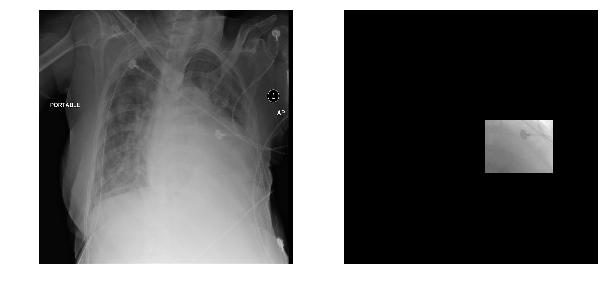

In [10]:
def visualize_random_image(dataset):
    class_ids = [0]
    while class_ids[0] == 0:
        image_id = random.choice(range(len(dataset.image_fps)))
        print(image_id)
        image_fp = dataset.image_fps[image_id]
        image = dataset.show_image(image_id)
        boxes, class_ids, masks = dataset.load_bbox(image_id, scale_factor=1)
        #print(boxes)
        #image, boxes = seq(image, boxes)
        if len(boxes) == 0:
            continue
        mask_instance = np.zeros((dataset.orig_height, dataset.orig_width), dtype=np.uint8)
        xmin, ymin, xmax, ymax = boxes[0][0], boxes[0][1], boxes[0][2], boxes[0][3]
        mask = cv2.rectangle(mask_instance, (xmin, ymin), (xmax, ymax), 255, -1)
        mask = np.array(mask)

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    masked = np.zeros(image.shape[:2])
    masked = image[:, :, 0] * mask
    
    plt.imshow(masked, cmap='gray')
    plt.axis('off')


img_size = 1024
dataset = RSNADataset(image_fps[:2000], image_annotations, img_size, img_size, train=True, transforms=True)

for i in range(1):
    visualize_random_image(dataset)

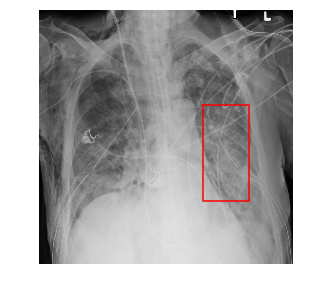

In [11]:
def draw(img, boxes):
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    for box in boxes:
        x_0, y_0 = box[0], box[1]
        x_1, y_1 = box[2], box[3]
        plt.plot((x_0, x_1, x_1, x_0, x_0),
                 (y_0, y_0, y_1, y_1, y_0), color = 'red')

img_size = 1024
dataset = RSNADataset(image_fps[:2000], image_annotations, img_size, img_size, train=True, transforms=True)

for i in range(1):
    img, target = next(iter(dataset))
    if target['boxes'][0][0] == 0:
        continue
    img_view = F.to_pil_image(img)
    draw(img_view, target['boxes'])
    #print(i)
    break

## Function for getting the model

In [12]:
def get_model(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Заменим "голову" классификатора на новую, которую обучим на нашем датасете
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256),),
                                       aspect_ratios=((0.25, 0.5, 1.0, 1.5, 2.0),))
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                    output_size=32,
                                                    sampling_ratio=2)
    model.box_roi_pool = roi_pooler
    model.rpn_anchor_generator = anchor_generator

    return model

## Support functions for training and evaluation of the quality

In [13]:
# source: https://www.kaggle.com/chenyc15/mean-average-precision-metric
def iou(box1, box2):
    x11, y11, x12, y12 = box1
    x21, y21, x22, y22 = box2
    
    w1 = x12 - x11
    h1 = y12 - y11
    w2 = x22 - x21
    h2 = y22 - y21
    
    area1, area2 = w1 * h1, w2 * h2
    xi1, yi1, xi2, yi2 = max([x11, x21]), max([y11, y21]), min([x12, x22]), min([y12, y22])
    
    if xi2 <= xi1 or yi2 <= yi1:
        return 0
    else:
        intersect = (xi2 - xi1) * (yi2 - yi1)
        union = area1 + area2 - intersect
        return intersect / union


def map_iou(boxes_true, boxes_pred, scores, thresholds = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]):
    """
    Mean average precision at differnet intersection over union (IoU) threshold
    
    input:
        boxes_true: Mx4 numpy array of ground true bounding boxes of one image. 
                    bbox format: (x1, y1, x2, y2)
        boxes_pred: Nx4 numpy array of predicted bounding boxes of one image. 
                    bbox format: (x1, y1, x2, y2)
        scores:     length N numpy array of scores associated with predicted bboxes
        thresholds: IoU shresholds to evaluate mean average precision on
    output: 
        map: mean average precision of the image
    """
    
    # According to the introduction, images with no ground truth bboxes will not be 
    # included in the map score unless there is a false positive detection (?)
        
    # return None if both are empty, don't count the image in final evaluation (?)
    if len(boxes_true) == 0 and len(boxes_pred) == 0:
        return None
    
    assert boxes_true.shape[1] == 4 or boxes_pred.shape[1] == 4, "boxes should be 2D arrays with shape[1]=4"
    if len(boxes_pred):
        assert len(scores) == len(boxes_pred), "boxes_pred and scores should be same length"
        # sort boxes_pred by scores in decreasing order
        boxes_pred = boxes_pred[np.argsort(scores)[::-1], :]
    
    map_total = 0
    
    # loop over thresholds
    for t in thresholds:
        matched_bt = set()
        tp, fn = 0, 0
        for i, bt in enumerate(boxes_true):
            matched = False
            for j, bp in enumerate(boxes_pred):
                miou = iou(bt, bp)
                if miou >= t and not matched and j not in matched_bt:
                    matched = True
                    tp += 1 # bt is matched for the first time, count as TP
                    matched_bt.add(j)
            if not matched:
                fn += 1 # bt has no match, count as FN
                
        fp = len(boxes_pred) - len(matched_bt) # FP is the bp that not matched to any bt
        m = tp / (tp + fn + fp)
        map_total += m
    
    return map_total / len(thresholds)


def evaluate(model, data_loader, device):
    boxes_pred = []
    boxes_true = []
    scores = []
    summ = 0
    count = 0
    with torch.no_grad():
        model.eval()

        for images, targets in tqdm_notebook(data_loader):
            boxes_true_mini_batch = [np.array(item["boxes"]) for item in targets]
            labels_true_mini_batch = [np.array(item["labels"]) for item in targets]
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            torch.cuda.synchronize()
            outputs = model(images)
            outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]

            res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
            boxes_pred_mini_batch = [np.array(res["boxes"].to("cpu")) for res in outputs]
            scores_mini_batch = [np.array(res["scores"].to("cpu")) for res in outputs]
            labels_mini_batch = [np.array(res["labels"].to("cpu")) for res in outputs]

            for img_num in range(len(images)):
                if np.all(labels_true_mini_batch[img_num] == 0):
                    if (labels_mini_batch[img_num].size == 0) or np.all(labels_mini_batch[img_num] == 0):
                        continue
                    else:
                        count += 1
                else:
                    curr_map_iou = map_iou(boxes_true_mini_batch[img_num], 
                                           boxes_pred_mini_batch[img_num], 
                                           scores_mini_batch[img_num])
                    summ += curr_map_iou
                    count += 1
                
    return summ / count


def collate_fn(batch):
    return tuple(zip(*batch))


def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

## Training and validation

In [14]:
def make_validation(images_files, cv, params):
    img_size = params.get("img_size", 1024)
    num_classes = params.get("num_classes", 2)
    num_epochs = params.get("num_epochs", 5)
    device = params.get("device", "cpu")
    
    scores = np.zeros(len(cv))
    for fold_num, (train_idx, val_idx) in enumerate(cv):
        train_images = list(images_files[train_idx])
        # We will only train on images with pneumonia
        train_images = [filename for filename in train_images if image_annotations[filename][0].Target > 0]
        val_images = list(images_files[val_idx])

        dataset = RSNADataset(train_images, image_annotations, img_size, img_size, train=True, transforms=False)

        dataset_val = RSNADataset(val_images, image_annotations, img_size, img_size, train=False, transforms=False)

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=6, shuffle=True, num_workers=8, collate_fn=collate_fn)

        data_loader_val = torch.utils.data.DataLoader(
            dataset_val, batch_size=6, shuffle=False, num_workers=8,
            collate_fn=collate_fn)

        model = get_model(num_classes)

        model.to(device)

        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr=0.005,
                                    momentum=0.9, weight_decay=0.00005)

        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                       step_size=2,
                                                       gamma=0.1)



        for epoch in range(num_epochs):
            print("epoch {}".format(epoch))
            train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)

            lr_scheduler.step()

            fold_score = evaluate(model, data_loader_val, device=device)
            print("score: {}".format(fold_score))
            scores[fold_num] = fold_score
        
        torch.save(model.state_dict(), "fold_num_{}_model".format(fold_num))
        del model
        
    print("average val score: {}".format(np.mean(scores)))

In [15]:
# Use more partitions for accurate validation
n_splits = 1
cv = list(ShuffleSplit(n_splits=n_splits, random_state=RANDOM_SEED, test_size=0.2).split(np.zeros((len(image_fps), 1)),
                                                                   np.zeros(len(image_fps))))

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
num_classes = 2
img_size = 1024
print("your device: {}".format(device))

params = {"img_size": img_size, "num_classes": num_classes, "num_epochs": 5, "device": device}

images_files = np.array(image_fps)

make_validation(images_files=images_files, cv=cv, params=params)

your device: cuda


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /tmp/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 115MB/s]


epoch 0
Epoch: [0]  [  0/797]  eta: 7:17:14  lr: 0.005000  loss: 2.8113 (2.8113)  loss_classifier: 0.9493 (0.9493)  loss_box_reg: 0.0656 (0.0656)  loss_mask: 1.7204 (1.7204)  loss_objectness: 0.0622 (0.0622)  loss_rpn_box_reg: 0.0138 (0.0138)  time: 32.9161  data: 24.5932  max mem: 4110
Epoch: [0]  [ 10/797]  eta: 1:07:06  lr: 0.005000  loss: 1.1555 (1.3067)  loss_classifier: 0.1646 (0.2346)  loss_box_reg: 0.0925 (0.0897)  loss_mask: 0.8021 (0.9265)  loss_objectness: 0.0417 (0.0422)  loss_rpn_box_reg: 0.0138 (0.0138)  time: 5.1161  data: 3.1480  max mem: 4387
Epoch: [0]  [ 20/797]  eta: 0:48:32  lr: 0.005000  loss: 1.0251 (1.1502)  loss_classifier: 0.1319 (0.1858)  loss_box_reg: 0.0832 (0.0841)  loss_mask: 0.7151 (0.8223)  loss_objectness: 0.0410 (0.0435)  loss_rpn_box_reg: 0.0130 (0.0146)  time: 2.2898  data: 0.9506  max mem: 4387
Epoch: [0]  [ 30/797]  eta: 0:40:04  lr: 0.005000  loss: 0.9573 (1.0649)  loss_classifier: 0.1186 (0.1654)  loss_box_reg: 0.0777 (0.0860)  loss_mask: 0.6919


score: 0.013802388681171953
epoch 1
Epoch: [1]  [  0/797]  eta: 6:27:37  lr: 0.005000  loss: 0.5478 (0.5478)  loss_classifier: 0.1266 (0.1266)  loss_box_reg: 0.1178 (0.1178)  loss_mask: 0.2793 (0.2793)  loss_objectness: 0.0140 (0.0140)  loss_rpn_box_reg: 0.0101 (0.0101)  time: 29.1810  data: 27.5710  max mem: 4756
Epoch: [1]  [ 10/797]  eta: 0:57:25  lr: 0.005000  loss: 0.5478 (0.5566)  loss_classifier: 0.1067 (0.1100)  loss_box_reg: 0.0941 (0.0891)  loss_mask: 0.2826 (0.3327)  loss_objectness: 0.0140 (0.0149)  loss_rpn_box_reg: 0.0101 (0.0099)  time: 4.3784  data: 2.9439  max mem: 4756
Epoch: [1]  [ 20/797]  eta: 0:45:27  lr: 0.005000  loss: 0.5557 (0.5847)  loss_classifier: 0.1035 (0.1105)  loss_box_reg: 0.0892 (0.0888)  loss_mask: 0.3192 (0.3626)  loss_objectness: 0.0115 (0.0130)  loss_rpn_box_reg: 0.0093 (0.0097)  time: 2.2273  data: 0.7979  max mem: 4756
Epoch: [1]  [ 30/797]  eta: 0:40:26  lr: 0.005000  loss: 0.5636 (0.5764)  loss_classifier: 0.1106 (0.1096)  loss_box_reg: 0.086


score: 0.017401442825725408
epoch 2
Epoch: [2]  [  0/797]  eta: 5:55:45  lr: 0.000500  loss: 0.8829 (0.8829)  loss_classifier: 0.1338 (0.1338)  loss_box_reg: 0.0970 (0.0970)  loss_mask: 0.6210 (0.6210)  loss_objectness: 0.0168 (0.0168)  loss_rpn_box_reg: 0.0144 (0.0144)  time: 26.7823  data: 25.2241  max mem: 4756
Epoch: [2]  [ 10/797]  eta: 0:59:51  lr: 0.000500  loss: 0.5701 (0.6096)  loss_classifier: 0.1119 (0.1080)  loss_box_reg: 0.0910 (0.0915)  loss_mask: 0.3352 (0.3895)  loss_objectness: 0.0092 (0.0106)  loss_rpn_box_reg: 0.0091 (0.0100)  time: 4.5641  data: 3.0807  max mem: 4756
Epoch: [2]  [ 20/797]  eta: 0:45:05  lr: 0.000500  loss: 0.5546 (0.6102)  loss_classifier: 0.1054 (0.1091)  loss_box_reg: 0.0895 (0.0894)  loss_mask: 0.3430 (0.3888)  loss_objectness: 0.0093 (0.0121)  loss_rpn_box_reg: 0.0107 (0.0109)  time: 2.3172  data: 0.8782  max mem: 4756
Epoch: [2]  [ 30/797]  eta: 0:39:35  lr: 0.000500  loss: 0.5471 (0.5878)  loss_classifier: 0.1118 (0.1131)  loss_box_reg: 0.086


score: 0.02252530602797387
epoch 3
Epoch: [3]  [  0/797]  eta: 3:45:29  lr: 0.000500  loss: 0.4673 (0.4673)  loss_classifier: 0.0928 (0.0928)  loss_box_reg: 0.0899 (0.0899)  loss_mask: 0.2652 (0.2652)  loss_objectness: 0.0124 (0.0124)  loss_rpn_box_reg: 0.0069 (0.0069)  time: 16.9755  data: 15.4718  max mem: 4762
Epoch: [3]  [ 10/797]  eta: 1:00:36  lr: 0.000500  loss: 0.5095 (0.5136)  loss_classifier: 0.0985 (0.0951)  loss_box_reg: 0.0832 (0.0807)  loss_mask: 0.3130 (0.3192)  loss_objectness: 0.0099 (0.0096)  loss_rpn_box_reg: 0.0085 (0.0089)  time: 4.6212  data: 3.1496  max mem: 4762
Epoch: [3]  [ 20/797]  eta: 0:44:44  lr: 0.000500  loss: 0.5095 (0.5055)  loss_classifier: 0.0988 (0.1009)  loss_box_reg: 0.0807 (0.0834)  loss_mask: 0.3058 (0.3028)  loss_objectness: 0.0081 (0.0091)  loss_rpn_box_reg: 0.0094 (0.0093)  time: 2.7784  data: 1.3010  max mem: 4762
Epoch: [3]  [ 30/797]  eta: 0:38:46  lr: 0.000500  loss: 0.4384 (0.4912)  loss_classifier: 0.1014 (0.1015)  loss_box_reg: 0.0790


score: 0.02315534297546015
epoch 4
Epoch: [4]  [  0/797]  eta: 6:18:08  lr: 0.000050  loss: 0.3967 (0.3967)  loss_classifier: 0.1120 (0.1120)  loss_box_reg: 0.0806 (0.0806)  loss_mask: 0.1886 (0.1886)  loss_objectness: 0.0089 (0.0089)  loss_rpn_box_reg: 0.0065 (0.0065)  time: 28.4680  data: 26.9272  max mem: 4762
Epoch: [4]  [ 10/797]  eta: 1:08:27  lr: 0.000050  loss: 0.4521 (0.4998)  loss_classifier: 0.1140 (0.1206)  loss_box_reg: 0.0937 (0.0999)  loss_mask: 0.1888 (0.2581)  loss_objectness: 0.0089 (0.0109)  loss_rpn_box_reg: 0.0096 (0.0102)  time: 5.2198  data: 3.8784  max mem: 4762
Epoch: [4]  [ 20/797]  eta: 0:48:05  lr: 0.000050  loss: 0.4608 (0.5032)  loss_classifier: 0.1018 (0.1100)  loss_box_reg: 0.0891 (0.0919)  loss_mask: 0.2555 (0.2831)  loss_objectness: 0.0074 (0.0091)  loss_rpn_box_reg: 0.0084 (0.0091)  time: 2.4755  data: 1.1518  max mem: 4762
Epoch: [4]  [ 30/797]  eta: 0:40:33  lr: 0.000050  loss: 0.4506 (0.4744)  loss_classifier: 0.0997 (0.1071)  loss_box_reg: 0.0800


score: 0.023747056136108963
average val score: 0.023747056136108963


## Functions for getting final predictions

In [16]:
def load_test_image(img_path, img_size):
    ds = pydicom.read_file(img_path)
    image = ds.pixel_array
    image = np.array(Image.fromarray(image).resize((img_size, img_size)))
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1)
    image = np.rollaxis(image, 2, 0) / 255
    return torch.Tensor(image)


def get_test_predictions(model, test_images, device, img_size):
    """
    Predictions for the test
    """
    sub = []
    min_conf = 0
    imgs_info = []
    scale_factor = 1024 / img_size
    with torch.no_grad():
        model.eval()

        for img_path in tqdm_notebook(test_images):
            images = [load_test_image(img_path, img_size)]
            images = list(img.to(device) for img in images)

            torch.cuda.synchronize()
            outputs = model(images)
            outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]

            boxes_pred_mini_batch = [np.array(res["boxes"].to("cpu")) for res in outputs]
            scores_mini_batch = [np.array(res["scores"].to("cpu")) for res in outputs]

            for i in range(len(images)):
                patient_id = img_path.split(".dcm")[0].split("stage_2_test_images/")[-1]
                img_info = dict()
                img_info["patient_id"] = patient_id
                img_info["boxes"] = boxes_pred_mini_batch[i]
                img_info["scores"] = scores_mini_batch[i]
                imgs_info.append(img_info)                
    return imgs_info


def get_sub_list(imgs_info, img_size, min_conf=0.7):
    """
    Write predictions in the correct format
    """
    sub = []
    scale_factor = 1024 / img_size
    for img_info in imgs_info:
        patient_id = img_info["patient_id"]
        boxes_pred_mini_batch = img_info["boxes"]
        scores_mini_batch = img_info["scores"]

        result_str = "{},".format(patient_id)
        for bbox_num in range(boxes_pred_mini_batch.shape[0]):
            if scores_mini_batch[bbox_num] > min_conf:
                result_str += " {:1.2f} ".format(np.round(scores_mini_batch[bbox_num], 2))
                x_min = int(np.round(boxes_pred_mini_batch[bbox_num, 0] * scale_factor))
                y_min = int(np.round(boxes_pred_mini_batch[bbox_num, 1] * scale_factor))
                width = int(np.round(boxes_pred_mini_batch[bbox_num, 2] * scale_factor)) - x_min
                height = int(np.round(boxes_pred_mini_batch[bbox_num, 3] * scale_factor)) - y_min
                result_str += "{} {} {} {}".format(x_min, y_min, width, height)
        sub.append(result_str + "\n")
    return sub


def write_submission(sub, filename="submission.csv"):
    with open(filename, mode="w") as f:
        header = "patientId,PredictionString\n"
        f.write(header)
        for line in sub:
            f.write(line)

In [17]:
model = get_model(num_classes=num_classes)
model.load_state_dict(torch.load("fold_num_0_model"))
model.to(device)

test_images = get_dicom_fps(os.path.join(data_path, "stage_2_test_images"))

imgs_info = get_test_predictions(model, test_images, device, img_size)

# min_conf -- the minimum threshold of certainty in order to read an object with pneumonia
sub_list = get_sub_list(imgs_info, img_size, min_conf=0.7)

write_submission(sub_list)